In [1]:
import networkx as nx
import torch

from src.archetypes import BiAA, SBM, DBiAA, DSBM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
k = 3
N = 50
sizes = [N] * k

likelihood = "poisson"
assignment = "hard"

## Generating a stochastic block model graph

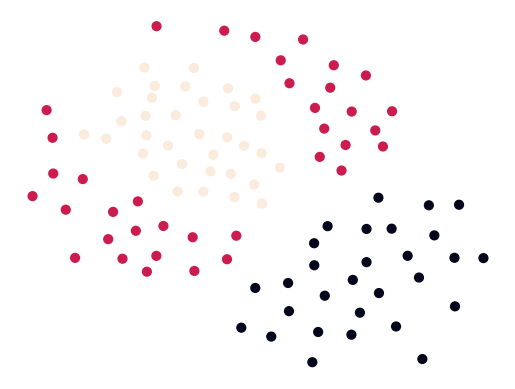

In [3]:
from itertools import chain

np.random.seed(0)
probs = np.random.uniform(0, 1, (3, 3))
probs = torch.tensor(
    [
        [0.9, 0.2, 0.1],
        [0.2, 0.0, 0.7],
        [0.1, 0.7, 0.7]
    ]
)

g = nx.stochastic_block_model(sizes, probs, directed=True)

g_sub = g.subgraph(np.random.choice(N * k, 100, replace=False))
c_sub = np.array(list(chain(*[[i] * N for i in range(k)])))[list(g_sub.nodes)]

pos_sub = nx.spring_layout(g_sub)

nx.draw_networkx_nodes(g_sub, pos_sub, nodelist=g_sub.nodes(), node_color=c_sub, node_size=40)
# nx.draw_networkx_edges(g_sub, pos_sub, alpha=0.05)
plt.axis("off")
plt.show()

In [4]:
a = nx.adjacency_matrix(g)
a = a.astype(np.float32).todense()[np.random.choice(N * k, N * k, replace=False), :][:, np.random.choice(N * k, N * k, replace=False)]
a = torch.tensor(a)

/var/folders/tj/q2qz82qj46qf7mwzd_jqkxnc0000gn/T/ipykernel_38900/2444559133.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(g)


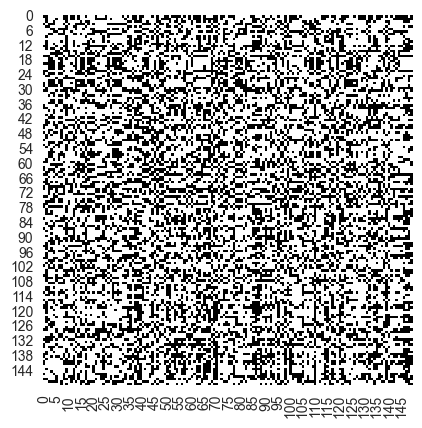

In [5]:
cmap = sns.color_palette("Greys", as_cmap=True)
sns.heatmap(a, cmap=cmap, square=True, cbar=False)
plt.show()

## BiAA method

0
1
2
3
4
5
6
7
8
9


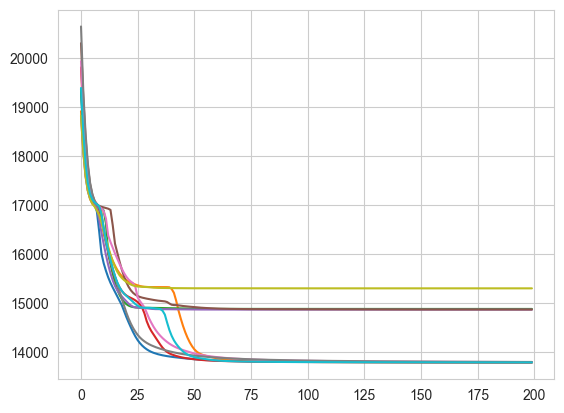

In [6]:
model_biaa = None
z_biaa = []
for _ in range(10):
    print(_)
    model_i = DSBM((k, k), a, likelihood=likelihood, assignment=assignment)
    model_i.fit(200, learning_rate=0.05)
    z_biaa += [model_i.Z]
    if not model_biaa or  model_i.losses[-1] < model_biaa.losses[-1]:
        model_biaa = model_i

    plt.plot(model_i.losses)
plt.show()

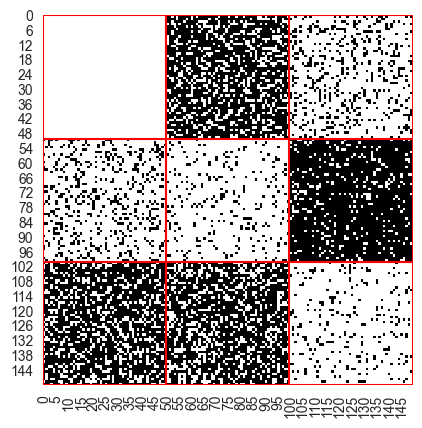

In [7]:
from src.archetypes.visualization import order_data_hard

sorted_a, hlines, vlines = order_data_hard(a, model_biaa)

sns.heatmap(sorted_a, cmap=cmap, square=True, cbar=False)
for y in hlines:
    plt.axhline(y=y, c="r")
for x in vlines:
    plt.axvline(x=x, c="r")

plt.show()

PIAUC
ROC - AUC

In [8]:
a_zero = a.clone()
x, y = np.where(a == 1)
i = np.random.choice(len(x), round(len(x) / 4), replace=False)
x_i = x[i]
y_i = y[i]
a_zero[x_i, y_i] = 0
x_zero, y_zero = np.where(a_zero == 0)

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

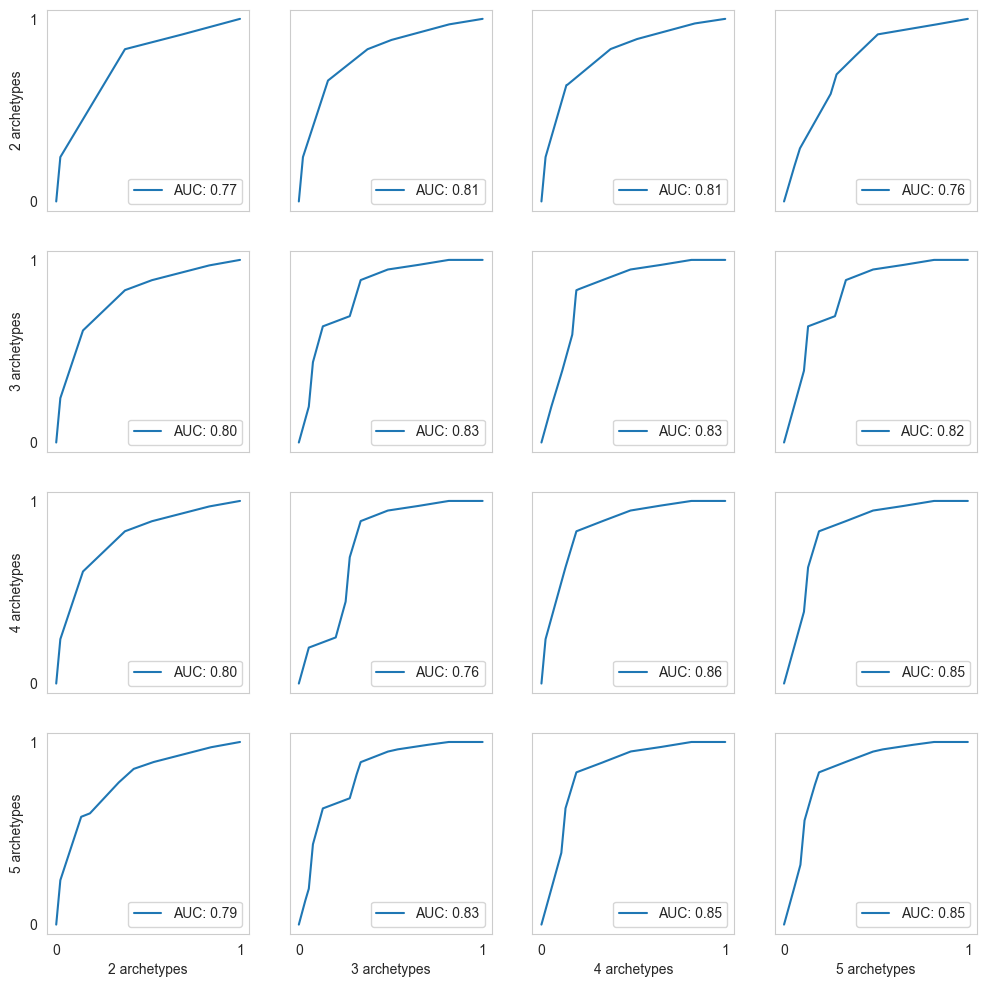

In [11]:
k0_min, k0_max = 2, 6
k1_min, k1_max = 2, 6

fig, axes = plt.subplots(k0_max - k0_min, k1_max - k1_min, figsize=((k0_max - k0_min) * 3, (k1_max - k1_min) * 3))

axes = axes
for k0 in range(k0_min, k0_max):
    for k1 in range(k1_min, k1_max):
        ax = axes[k0 - k0_min, k1 - k1_min]

        model_biaa = None
        z_biaa = []
        for _ in range(3):
            model_i = DSBM((k0, k1), a_zero, likelihood=likelihood, assignment=assignment)
            model_i.fit(200, learning_rate=0.05)
            z_biaa += [model_i.Z]
            if not model_biaa or  model_i.losses[-1] < model_biaa.losses[-1]:
                model_biaa = model_i

        a_rec = model_biaa.A @ model_biaa.Z @ model_biaa.D

        roc = roc_curve(a[x_zero, y_zero].detach().numpy(), a_rec[x_zero, y_zero].detach().numpy(), pos_label=1,
                        drop_intermediate=False)
        auc = roc_auc_score(a[x_zero, y_zero].detach().numpy(), a_rec[x_zero, y_zero].detach().numpy())

        ax.plot(roc[0], roc[1], label=f"AUC: {auc:.2f}")
        ax.set(xlabel=f"{k1} archetypes", ylabel=f"{k0} archetypes")
        ax.grid(False)
        ax.label_outer()
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.legend(loc='lower right')
plt.show()

In [ ]:
print(model_biaa.a)